# Legal document classification in zero-shot cross lingual transfer setting

# Part I: Data acquisition and exploration

Date: May 2025

Project of course: Natural Language Processing - ENSAE 3A S2

Author: Noémie Guibé

In [36]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from collections import defaultdict
from collections import Counter
from itertools import combinations

# 1 - Load and reduce data

In [2]:
# import train, test and dev datasets - Note: this take 2-3 min
with open('../train.jsonl', 'r', encoding='utf-8') as f:
    train_ds = [json.loads(line) for line in f]
train_df = pd.DataFrame(train_ds).assign(split='train')
print(f'Train dataset has {len(train_df)} rows, as expected')

with open('../dev.jsonl', 'r', encoding='utf-8') as f:
    dev_ds = [json.loads(line) for line in f]
dev_df   = pd.DataFrame(dev_ds).assign(split='dev')
print(f'Dev dataset has {len(dev_df)} rows, as expected')

with open('../test.jsonl', 'r', encoding='utf-8') as f:
    test_ds = [json.loads(line) for line in f]
test_df  = pd.DataFrame(test_ds).assign(split='test')
print(f'Test dataset has {len(test_df)} rows, as expected')

df = pd.concat([train_df, dev_df, test_df], ignore_index=True)
df.head()

Train dataset has 55000 rows, as expected
Dev dataset has 5000 rows, as expected
Test dataset has 5000 rows, as expected


,celex_id,publication_date,text,eurovoc_concepts,split
0,32006D0213,2006-03-06,{'bg': '32006D0213 L 079/27 ОФИЦИАЛЕН ВЕСТНИК ...,"{'level_1': ['100160', '100155', '100158', '10...",train
1,32003R1330,2003-07-25,"{'bg': None, 'cs': None, 'da': 'Kommissionens ...","{'level_1': ['100148', '100157'], 'level_2': [...",train
2,32003R1786,2003-09-29,{'bg': '32003R1786 L 270/114 ОФИЦИАЛЕН ВЕСТНИК...,"{'level_1': ['100147', '100146', '100156'], 'l...",train
3,31985R2590,1985-09-13,"{'bg': None, 'cs': None, 'da': '***** KOMMISSI...","{'level_1': ['100150', '100157', '100146', '10...",train
4,31993R1103,1993-04-30,"{'bg': None, 'cs': None, 'da': 'KOMMISSIONENS ...","{'level_1': ['100161', '100147', '100152', '10...",train


## Data set reduction

Choosing one language per major language family (e.g., Germanic, Romance, Slavic, Uralic) preserves:

Syntactic and morphological variety (important for multilingual modeling)

A decent degree of label variability and document diversity

Faster processing due to smaller subsets

It gives you the ability to:

Still study multilingual behavior

Reduce computational cost

Retain enough complexity for meaningful insights

In [3]:
langs_to_keep = ['en', 'de', 'fr', 'pl', 'fi'] 
df_reduced = df.copy()
df_reduced['text'] = df['text'].apply(lambda x: {lang: x[lang] for lang in langs_to_keep if lang in x and x[lang] is not None})

# Memory reduction
original_memory = df.memory_usage(deep=True).sum() / (1024 ** 2)  # Convert to MB
reduced_memory = df_reduced.memory_usage(deep=True).sum() / (1024 ** 2)
memory_reduction_percentage = ((original_memory - reduced_memory) / original_memory) * 100
print(f"Number of empty rows: {len(df_reduced[df_reduced['text'].apply(lambda x: len(x))==0])}")
print(df_reduced.iloc[0]['text'])
print(f"Memory reduction: {memory_reduction_percentage:.2f}% lighter")

Number of empty rows: 0
{'en': 'COMMISSION DECISION\nof 6 March 2006\nestablishing the classes of reaction-to-fire performance for certain construction products as regards wood flooring and solid wood panelling and cladding\n(notified under document number C(2006) 655)\n(Text with EEA relevance)\n(2006/213/EC)\nTHE COMMISSION OF THE EUROPEAN COMMUNITIES,\nHaving regard to the Treaty establishing the European Community,\nHaving regard to Directive 89/106/EEC of 21 December 1988, on the approximation of laws, regulations and administrative provisions of the Member States relating to construction products (1), and in particular Article 20(2) thereof,\nWhereas:\n(1)\nDirective 89/106/EEC envisages that in order to take account of different levels of protection for construction works at national, regional or local level, it may be necessary to establish in the interpretative documents classes corresponding to the performance of products in respect of each essential requirement. Those docume

In [ ]:
# export
folder_path = "data/dataset"

os.makedirs(folder_path, exist_ok=True)
df_reduced.to_parquet('data/dataset/multi_eurlex_reduced.parquet', index=False)

# Law publication across years

c:\Users\guibe\anaconda3\envs\vscode\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


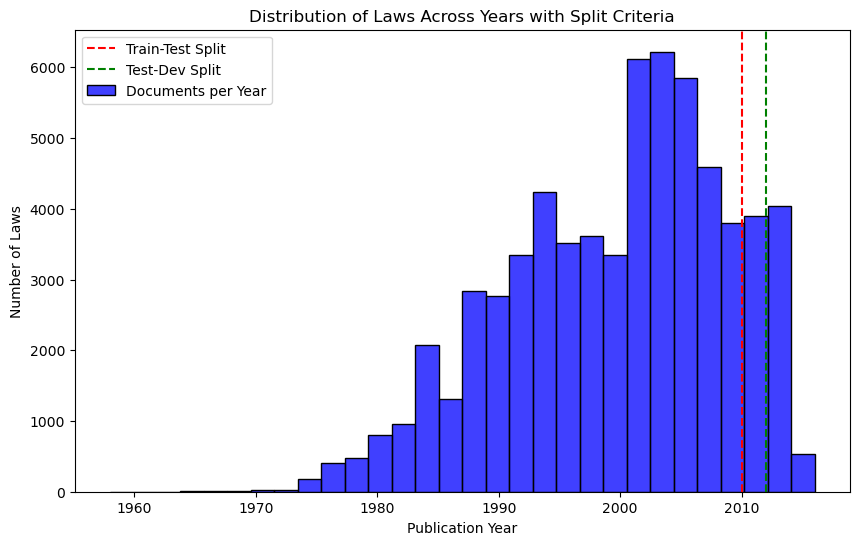

In [ ]:
# Convert 'publication_date' to datetime and extract year
df_reduced['publication_date'] = pd.to_datetime(df_reduced['publication_date'])
df_reduced['publication_year'] = df_reduced['publication_date'].dt.year

# Plot the distribution of documents by year with vertical lines for the split criteria
plt.figure(figsize=(10,6))
sns.histplot(df_reduced['publication_year'], kde=False, bins=30, color='blue', label='Documents per Year')
plt.axvline(x=2010, color='red', linestyle='--', label='Train-Test Split')
plt.axvline(x=2012, color='green', linestyle='--', label='Test-Dev Split')
plt.title('Distribution of Laws Across Years with Split Criteria')
plt.xlabel('Publication Year')
plt.ylabel('Number of Laws')
plt.legend()
plt.show()

# Document Length

In [8]:
# Calculate the length of the document for each language
def compute_lengths(text_dict):
    lengths = {lang: len(text_dict[lang]) for lang in langs_to_keep if text_dict.get(lang) is not None}
    return lengths
df_reduced['doc_lengths'] = df_reduced['text'].apply(compute_lengths)

# Then we compute the statistics for document lengths
all_lengths = []
for row in df_reduced['doc_lengths']:
    all_lengths.extend(row.values())  
overall_stats = pd.Series(all_lengths).describe()
print("Overall Document Length Statistics (across all languages):")
print(overall_stats)

Overall Document Length Statistics (across all languages):
count    2.806940e+05
mean     8.072066e+03
std      2.102396e+04
min      5.380000e+02
25%      2.047000e+03
50%      2.951000e+03
75%      5.859000e+03
max      1.440461e+06
dtype: float64


That max value is very high — possibly an outlier or a preprocessing issue (e.g., law with annexes). Might be worth inspecting or truncating for modeling.

The mean > median suggests a right-skewed distribution — common in legal corpora where a few laws are much longer than the rest.

c:\Users\guibe\anaconda3\envs\vscode\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


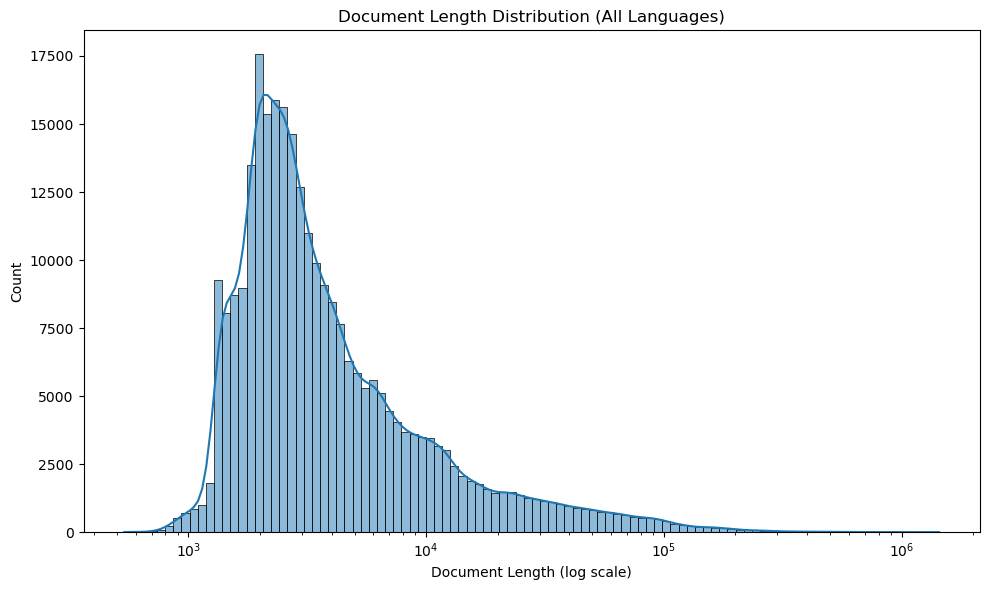

In [9]:
# Document length distribution overall
all_lengths_df = pd.DataFrame({'doc_length': all_lengths})
plt.figure(figsize=(10, 6))
sns.histplot(all_lengths_df['doc_length'], bins=100, log_scale=(True, False), kde=True)
plt.title('Document Length Distribution (All Languages)')
plt.xlabel('Document Length (log scale)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()



Document Length Statistics Per Language:

Statistics for en:
count    6.500000e+04
mean     7.477300e+03
std      1.913348e+04
min      5.660000e+02
25%      1.981000e+03
50%      2.835000e+03
75%      5.549250e+03
max      1.269363e+06
dtype: float64

Statistics for de:
count    6.500000e+04
mean     8.081598e+03
std      2.113035e+04
min      5.920000e+02
25%      2.108000e+03
50%      2.992000e+03
75%      5.914000e+03
max      1.361562e+06
dtype: float64

Statistics for fr:
count    6.500000e+04
mean     8.234370e+03
std      2.143805e+04
min      5.510000e+02
25%      2.129000e+03
50%      3.063000e+03
75%      6.058000e+03
max      1.440461e+06
dtype: float64

Statistics for pl:
count    3.319700e+04
mean     8.919184e+03
std      2.324453e+04
min      5.380000e+02
25%      2.032000e+03
50%      3.031000e+03
75%      6.362000e+03
max      1.381409e+06
dtype: float64

Statistics for fi:
count    5.249700e+04
mean     8.060043e+03
std      2.110993e+04
min      5.550000e+02
25%   

c:\Users\guibe\anaconda3\envs\vscode\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\guibe\anaconda3\envs\vscode\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\guibe\anaconda3\envs\vscode\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\guibe\anaconda3\envs\vscode\Lib\site-packages\seaborn\_oldcore.

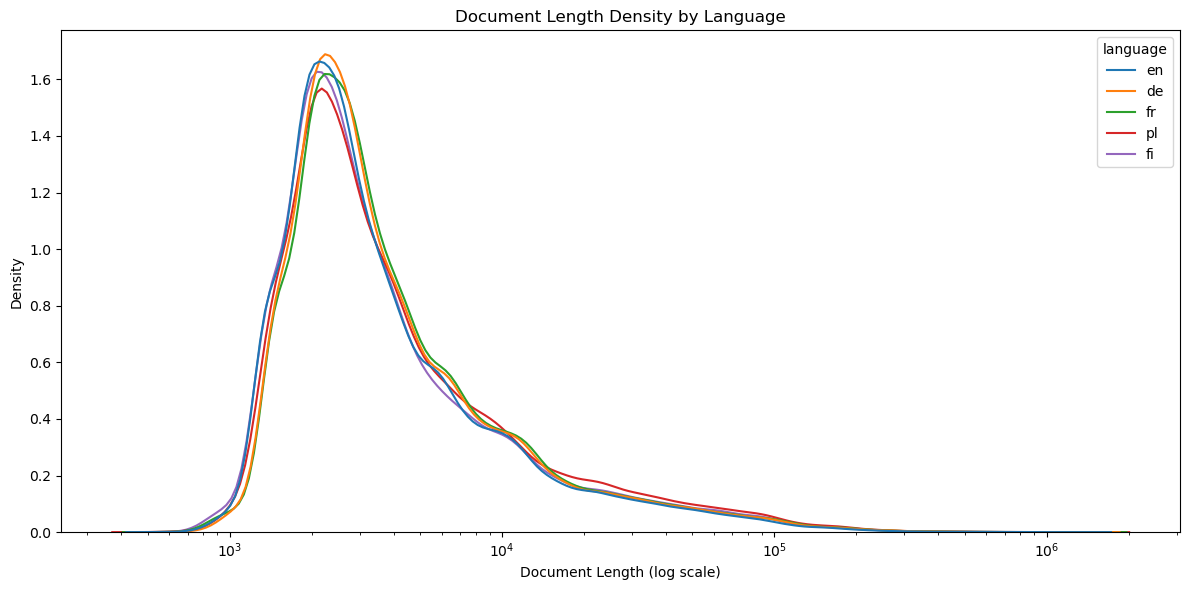

In [10]:
# We do the same per language
lengths_per_language = {lang: [] for lang in langs_to_keep}
for row in df_reduced['doc_lengths']:
    for lang, length in row.items():
        lengths_per_language[lang].append(length)
language_stats = {}
for lang, lengths in lengths_per_language.items():
    language_stats[lang] = pd.Series(lengths).describe()

print("\nDocument Length Statistics Per Language:")
for lang, stats in language_stats.items():
    print(f"\nStatistics for {lang}:")
    print(stats)

records = []
for lang, lengths in lengths_per_language.items():
    records.extend([{'length': l, 'language': lang} for l in lengths])

df_langs_only = pd.DataFrame(records)

# Plot per-language KDE curves
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_langs_only, x='length', hue='language', common_norm=False, log_scale=True, fill=False)

plt.title('Document Length Density by Language')
plt.xlabel('Document Length (log scale)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

In [11]:
# What are the characteristics of the very long laws?
df_reduced['max_doc_length'] = df_reduced['doc_lengths'].apply(lambda d: max(d.values(), default=0))
top_10 = df_reduced['max_doc_length'].nlargest(10)
top_10_df = df_reduced.loc[top_10.index].copy()
top_10_df['doc_length'] = top_10.values
top_10_df['index'] = top_10.index
print(top_10_df[['index', 'doc_length', 'split','publication_date']])


       index  doc_length  split publication_date
60074  60074     1440461   test       2013-06-26
15924  15924      926327  train       1993-07-02
63656  63656      743757   test       2013-12-02
6280    6280      703788  train       2002-04-17
64587  64587      609582   test       2014-05-15
53825  53825      587757  train       2001-10-10
40371  40371      565908  train       1994-11-30
42935  42935      564883  train       2009-11-25
10358  10358      563527  train       1999-09-29
63388  63388      520690   test       2014-05-15


6 out of the top 10 longest documents are in train, 4 are in test, 0 are in dev .

Older documents (e.g., from 1993-2002) are prevalent, which could suggest that there might be specific types of legislation (or areas) that tend to be longer.

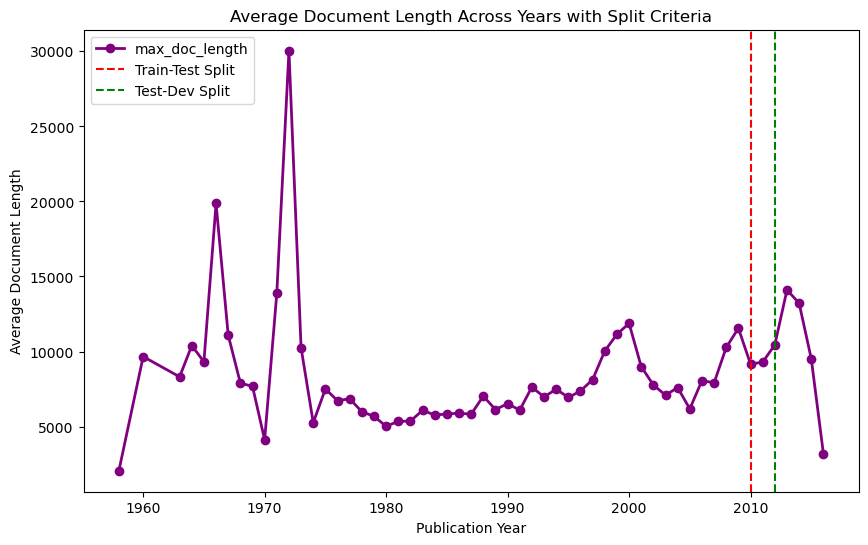

In [12]:
# Group by publication year and calculate the average document length per year
df_reduced['max_doc_length'] = df_reduced['doc_lengths'].apply(lambda d: max(d.values(), default=0)) 
avg_doc_length_per_year = df_reduced.groupby('publication_year')['max_doc_length'].mean()

# Plot the average document length per year with vertical lines for the split criteria
plt.figure(figsize=(10,6))
avg_doc_length_per_year.plot(kind='line', color='purple', marker='o', linestyle='-', linewidth=2)
plt.axvline(x=2010, color='red', linestyle='--', label='Train-Test Split')
plt.axvline(x=2012, color='green', linestyle='--', label='Test-Dev Split')
plt.title('Average Document Length Across Years with Split Criteria')
plt.xlabel('Publication Year')
plt.ylabel('Average Document Length')
plt.legend()
plt.show()

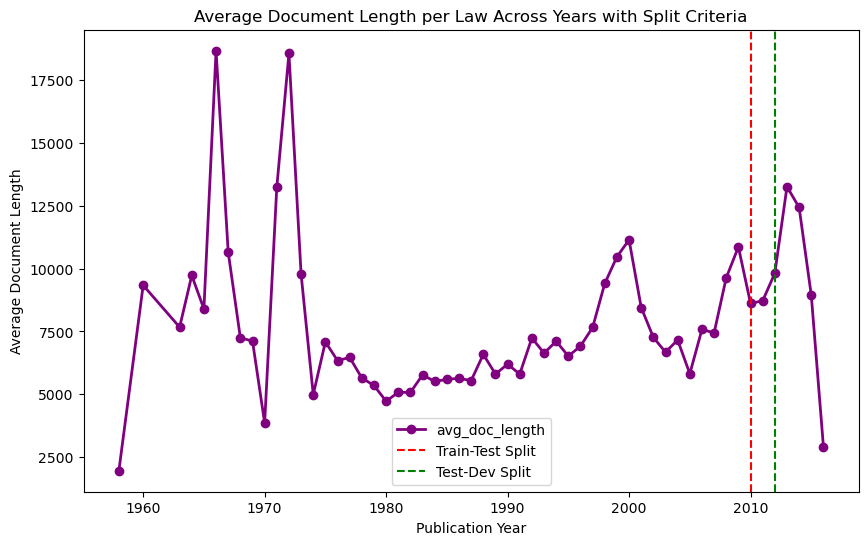

In [13]:
# Calculate the average document length for each law across languages from 'doc_lengths'
def avg_doc_length(doc_lengths):
    if doc_lengths is None or len(doc_lengths) == 0:
        return 0  
    return sum(doc_lengths.values()) / len(doc_lengths)

df_reduced['avg_doc_length'] = df_reduced['doc_lengths'].apply(avg_doc_length)

# Plot the average document length per year with other methods
df_reduced['publication_year'] = pd.to_datetime(df_reduced['publication_date']).dt.year
avg_doc_length_per_year = df_reduced.groupby('publication_year')['avg_doc_length'].mean()

plt.figure(figsize=(10,6))
avg_doc_length_per_year.plot(kind='line', color='purple', marker='o', linestyle='-', linewidth=2)
plt.axvline(x=2010, color='red', linestyle='--', label='Train-Test Split')
plt.axvline(x=2012, color='green', linestyle='--', label='Test-Dev Split')
plt.title('Average Document Length per Law Across Years with Split Criteria')
plt.xlabel('Publication Year')
plt.ylabel('Average Document Length')
plt.legend()
plt.show()

In [10]:
# drop documents longer than 500k 
df_reduced = df_reduced[df_reduced['max_doc_length']<500000]

In [ ]:
df_reduced.to_parquet('data/multi_eurlex_reduced.parquet', index=False)

# Language distribution

In [ ]:
# number of laws without all languages translations
len(df_reduced[df_reduced['text'].apply(lambda x: len(x))<4])

12248

In [ ]:
# First we look at the language Distribution Across All Documents

language_counts_all = df_reduced['text'].apply(lambda x: list(x.keys()) if x is not None else []).explode().value_counts()
total_docs = df_reduced.shape[0]
language_proportion_all = language_counts_all / total_docs
print('Language Proportion Across All Documents:')
print(language_proportion_all)

# And then for each split 
def language_distribution_by_split(split_name):
    df_split = df_reduced[df_reduced['split'] == split_name]
    split_language_counts = df_split['text'].apply(lambda x: list(x.keys()) if x is not None else []).explode().value_counts()
    total_docs_split = df_split.shape[0]
    split_language_proportion = split_language_counts / total_docs_split
    return split_language_proportion

train_language_proportion = language_distribution_by_split('train')
test_language_proportion = language_distribution_by_split('test')
dev_language_proportion = language_distribution_by_split('dev')


print('\nLanguage Proportion for Train Split:')
print(train_language_proportion)
print('\nLanguage Proportion for Test Split:')
print(test_language_proportion)
print('\nLanguage Proportion for Dev Split:')
print(dev_language_proportion)


Language Proportion Across All Documents:
text
en    1.000000
de    1.000000
fr    1.000000
fi    0.807646
pl    0.510723
Name: count, dtype: float64

Language Proportion for Train Split:
text
en    1.000000
de    1.000000
fr    1.000000
fi    0.772673
pl    0.421764
Name: count, dtype: float64

Language Proportion for Test Split:
text
en    1.0
de    1.0
fr    1.0
pl    1.0
fi    1.0
Name: count, dtype: float64

Language Proportion for Dev Split:
text
en    1.0
de    1.0
fr    1.0
pl    1.0
fi    1.0
Name: count, dtype: float64


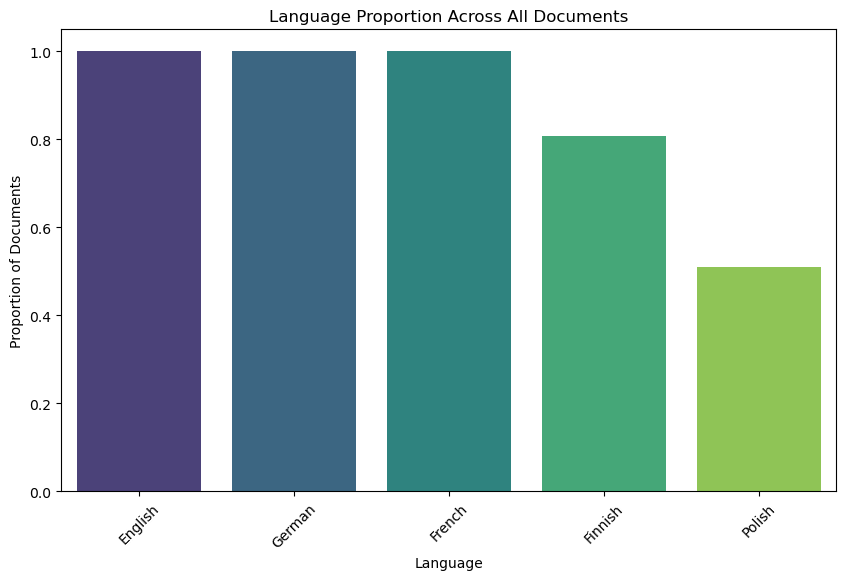

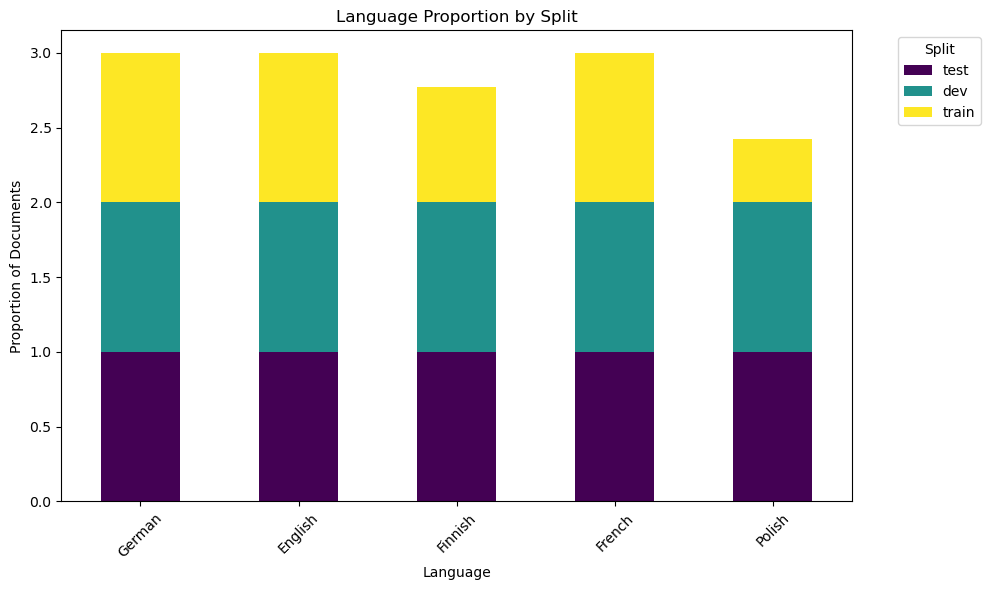

In [ ]:
language_full_names = {
    'en': 'English',
    'de': 'German',
    'fr': 'French',
    'pl': 'Polish',
    'fi': 'Finnish'
}

# Plot the Language Proportion Across All Documents
plt.figure(figsize=(10, 6))
sns.barplot(x=language_proportion_all.index, y=language_proportion_all.values, palette="viridis")
plt.title('Language Proportion Across All Documents')
plt.xlabel('Language')
plt.xticks(ticks=range(len(language_proportion_all.index)), labels=[language_full_names[lang] for lang in language_proportion_all.index], rotation=45)
plt.ylabel('Proportion of Documents')
plt.show()

# Plot Stacked Bar Chart for Language Proportion by Split
split_language_proportions = pd.DataFrame({
    'test': test_language_proportion,
    'dev': dev_language_proportion,
    'train': train_language_proportion
}).fillna(0)  

# Plotting stacked bar chart
split_language_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Language Proportion by Split')
plt.xlabel('Language')
plt.xticks(ticks=range(len(split_language_proportions.index)), labels=[language_full_names[lang] for lang in split_language_proportions.index], rotation=45)
plt.ylabel('Proportion of Documents')
plt.xticks(rotation=45)
plt.legend(title='Split', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  
plt.show()


All laws are translate in english, french and german so this is normal. Laws in the train and dev splits are also all translated for the languages we consider. (c.f. Table 1 in the article)

But only a bit more than half of train documents are translated in polish

# Label distribution

In [15]:
keys_to_keep = ['text', 'labels']

with open("data/labels/eurovoc_descriptors.json", "r", encoding="utf-8") as f:
    labels = json.load(f)

english_only = {k: v.get("en") for k, v in labels.items() if v.get("en") is not None}
labels = pd.DataFrame(list(english_only.items()), columns=["label_id", "label_description"])

with open("data/labels/eurovoc_concepts.json", "r", encoding="utf-8") as f:
    levels = json.load(f)
level_data = [
    {"label_id": label_id, "level": level}
    for level, label_ids in levels.items()
    for label_id in label_ids
]
df_levels = pd.DataFrame(level_data)
df_labels = pd.merge(labels, df_levels, on='label_id', how='inner')
df_labels =df_labels[df_labels['level']!='original']
print(f"Size of label level: \n {df_labels['level'].value_counts()}")

Size of label level: 
 level
level_4    3861
level_5    2284
level_3     567
level_6     481
level_2     127
level_7      43
level_1      21
level_8       6
Name: count, dtype: int64


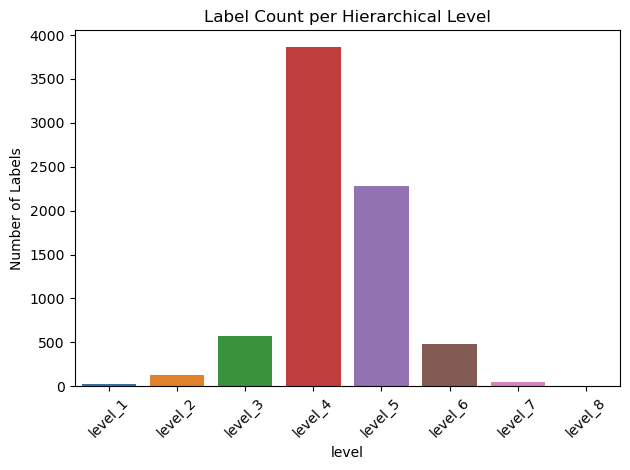

In [ ]:
# Or as a barplot:
level_counts = df_labels['level'].value_counts().sort_index()
sns.barplot(x=level_counts.index, y=level_counts.values)
plt.xticks(rotation=45)
plt.ylabel("Number of Labels")
plt.title("Label Count per Hierarchical Level")
plt.tight_layout()
plt.show()


In [ ]:
# overview of label description for level 1:
df_labels[df_labels['level']=='level_1']

,label_id,label_description,level
0,100149,social questions,level_1
2,100160,industry,level_1
4,100148,finance,level_1
6,100147,trade,level_1
8,100152,business and competition,level_1
10,100143,international relations,level_1
12,100156,"agriculture, forestry and fisheries",level_1
14,100158,"production, technology and research",level_1
16,100154,transport,level_1
18,100153,employment and working conditions,level_1


## To analyze label distribution and co-labeling we will focus on level 1

In [ ]:
# for that purpose we create a level 1 list-column
df_reduced['level_1_labels'] = df_reduced['eurovoc_concepts'].apply(lambda d: d.get('level_1', []))

# First we want to study labels repartition accross splits
def label_counts_by_split(df, split_name):
    labels = df[df['split'] == split_name]['level_1_labels'].explode()
    return Counter(labels)

train_dist = label_counts_by_split(df_reduced, 'train')
test_dist = label_counts_by_split(df_reduced, 'test')
dev_dist = label_counts_by_split(df_reduced, 'dev')

# Plot
dist_df = pd.DataFrame([train_dist, test_dist, dev_dist], index=['train', 'test', 'dev']).T.fillna(0).astype(int)

In [51]:
id_to_description = df_labels[df_labels['level'] == 'level_1'].set_index('label_id')['label_description'].to_dict()

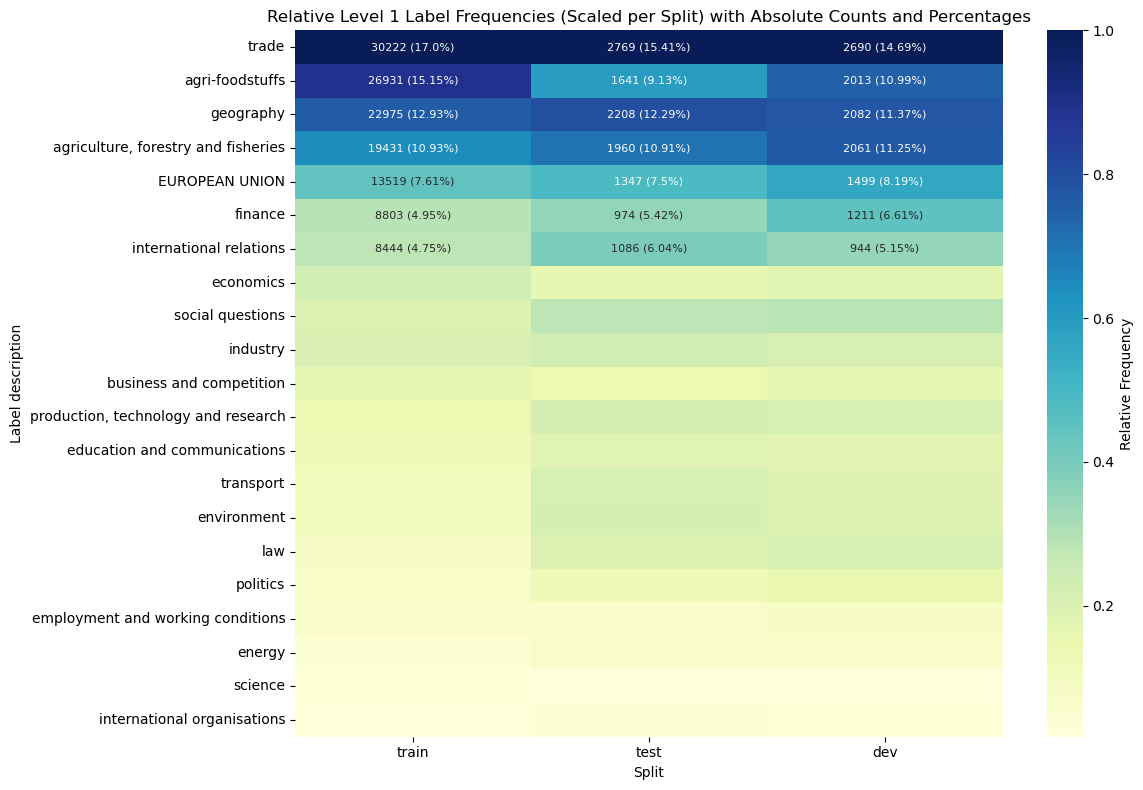

In [60]:
# First we want to study labels repartition accross splits
def label_counts_by_split(df, split_name):
    labels = df[df['split'] == split_name]['level_1_labels'].explode()
    return Counter(labels)

train_dist = label_counts_by_split(df_reduced, 'train')
test_dist = label_counts_by_split(df_reduced, 'test')
dev_dist = label_counts_by_split(df_reduced, 'dev')

# Plot
dist_df = pd.DataFrame([train_dist, test_dist, dev_dist], index=['train', 'test', 'dev']).T.fillna(0).astype(int)

top_n = 21  # show top x most common labels
top_labels = dist_df.sum(axis=1).sort_values(ascending=False).head(top_n).index

# Normalize each column (split) to [0, 1] range
col_normalized = dist_df.loc[top_labels].div(dist_df.loc[top_labels].max(axis=0), axis=1)

# Calculate absolute counts and percentages
absolute_counts = dist_df.loc[top_labels]
percentages = (absolute_counts / absolute_counts.sum(axis=0)) * 100

# Format annotations to show both counts and percentages
annotations = absolute_counts.astype(str) + " (" + percentages.round(2).astype(str) + "%)"

# Replace label IDs with descriptions in the index
absolute_counts.index = absolute_counts.index.map(id_to_description)
col_normalized.index = col_normalized.index.map(id_to_description)
annotations.index = annotations.index.map(id_to_description)

# Plot heatmap with both normalized values and absolute counts with percentages
plt.figure(figsize=(12, 8))
sns.heatmap(col_normalized, annot=annotations, fmt="s", cmap="YlGnBu", cbar_kws={'label': 'Relative Frequency'}, annot_kws={"size": 8})
plt.title("Relative Level 1 Label Frequencies (Scaled per Split) with Absolute Counts and Percentages")
plt.xlabel("Split")
plt.ylabel("Label description")
plt.tight_layout()
plt.show()

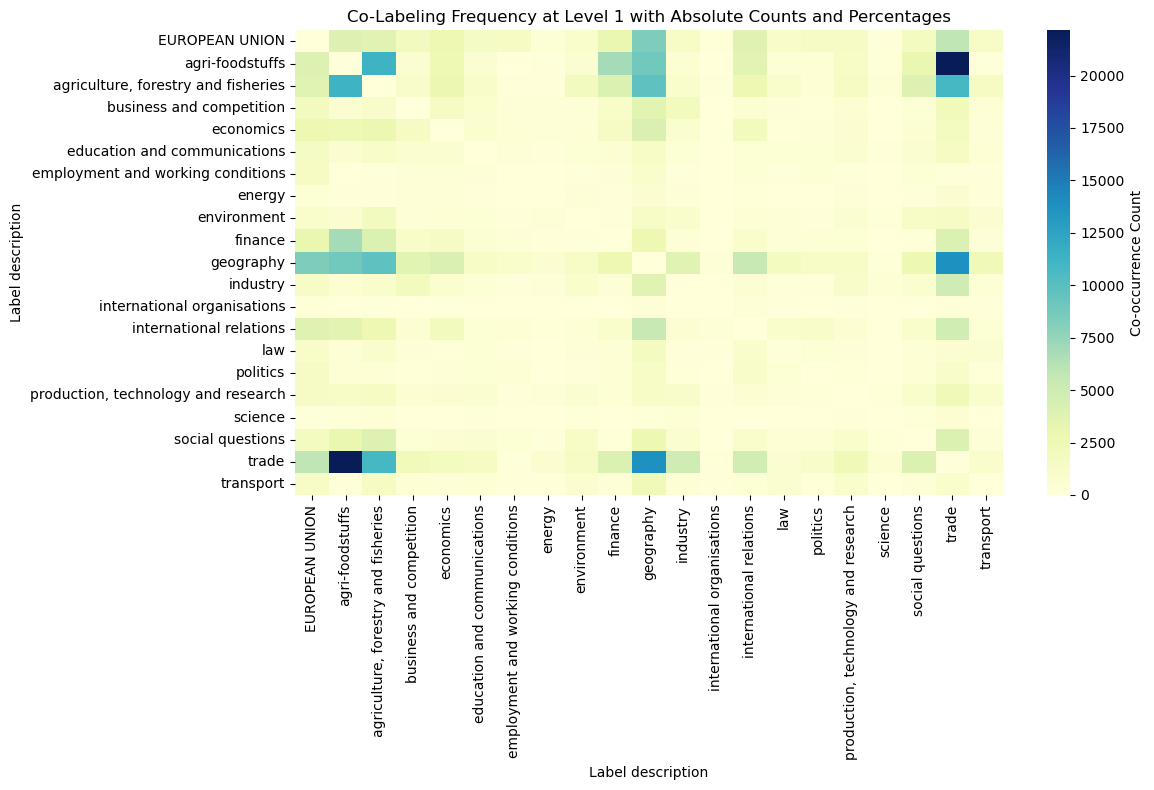

In [59]:
# Secondly we study the co-labelling of laws, which labels are often used together

def extract_level_1(concept):
    if isinstance(concept, dict) and 'level_1' in concept:
        level_1 = concept['level_1']
        return level_1 if isinstance(level_1, list) else []
    return []

level_1_labels = df_reduced['eurovoc_concepts'].apply(extract_level_1)

# Generate co-label pairs and count to compute matrix
co_label_pairs = []
for labels in level_1_labels:
    if isinstance(labels, list) and len(labels) >= 2:
        co_label_pairs.extend(combinations(sorted(labels), 2))  # sort to avoid duplicate pairs
multi_index = pd.MultiIndex.from_tuples(co_label_pairs, names=['Label_1', 'Label_2'])
co_label_series = pd.Series(1, index=multi_index)  # set value 1 for each pair
co_label_counts = co_label_series.groupby(level=[0, 1]).sum()
co_label_counts_df = co_label_counts.unstack(fill_value=0)

# Replace IDs with descriptions in the heatmap
co_label_counts_df.index = co_label_counts_df.index.map(id_to_description)
co_label_counts_df.columns = co_label_counts_df.columns.map(id_to_description)
co_label_counts_df = co_label_counts_df.dropna(axis=0, how='all').dropna(axis=1, how='all')
all_labels = sorted(set(co_label_counts_df.index).union(set(co_label_counts_df.columns)))

co_label_counts_df = co_label_counts_df.reindex(index=all_labels, columns=all_labels, fill_value=0)
co_label_counts_df = co_label_counts_df.add(co_label_counts_df.T, fill_value=0).astype(int)

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(co_label_counts_df, fmt="s", cmap="YlGnBu", cbar_kws={'label': 'Co-occurrence Count'})
plt.title("Co-Labeling Frequency at Level 1 with Absolute Counts and Percentages")
plt.xlabel("Label description")
plt.ylabel("Label description")
plt.tight_layout()
plt.show()